In [2]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['usenet', 'gab', 'reddit','voat', 'twitter', 'facebook']


# Power Law distribution

#### Fitta le power law

In [5]:
import pandas as pd
import powerlaw as pwl
import matplotlib.pyplot as plt
import os

# Funzione per caricare e analizzare i dati di ciascuna piattaforma
def analyze_platform_data(platform, root, columns_to_read, standard_columns):
    try:
        # Carica i dati da un file Parquet
        data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', 
                                columns=columns_to_read[platform])
        data.columns = standard_columns
        data['timestamp'] = pd.to_datetime(data['timestamp'])

        # Calcola il numero di utenti unici per post
        unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
        unique_users_per_post.columns = ['post_id', 'unique_users_count']

        # Salva i risultati in un CSV
        output_csv_path = os.path.join(root, 'PAPER', 'output', '1_section', f'1_users_in_thread_{platform}.csv')
        unique_users_per_post.to_csv(output_csv_path, index=False)
        
        # Fit della distribuzione Power Law
        fit_function = pwl.Fit(list(unique_users_per_post['unique_users_count']))
        
        # Stampa dei parametri della Power Law
        print(f"\nPlatform: {platform}")
        print(f"Alpha: {fit_function.power_law.alpha}")
        print(f"Sigma: {fit_function.power_law.sigma}")
        print(f"D: {fit_function.power_law.D}")
        
        # Confronto tra la Power Law e una distribuzione esponenziale (opzionale)
        comparison = fit_function.distribution_compare('power_law', 'exponential')
        print(f"Comparison between Power Law and Exponential: {comparison}")
        
        # Plot dei dati e della Power Law adattata
        plt.figure(figsize=(8, 6))
        fit_function.plot_pdf(color='b', linestyle='-', label='Empirical Data')  # PDF empirico
        fit_function.power_law.plot_pdf(color='r', linestyle='--', label='Fitted Power Law')  # Fit della Power Law
        plt.title(f"Power Law Fit for {platform.capitalize()}", fontsize=T)
        plt.xlabel('Unique Users per Post', fontsize=xl)
        plt.ylabel('Probability', fontsize=yl)
        plt.xticks( fontsize=t)
        plt.yticks(fontsize=t)
        plt.legend()
        plt.grid(True)

        # Salva il grafico come PNG
        plot_path = os.path.join(root, 'PAPER', 'output', 'plots', f'{platform}_power_law_fit.png')
        plt.savefig(plot_path)
        plt.close()
        
    except Exception as e:
        print(f"Error processing platform {platform}: {e}")



# Ciclo per analizzare ogni piattaforma
for platform in platforms:
    analyze_platform_data(platform, root, columns_to_read, standard_columns)


Calculating best minimal value for power law fit
xmin progress: 99%
Platform: gab
Alpha: 3.5292471415993325
Sigma: 0.03858411923607005
D: 0.02201761290675619
Comparison between Power Law and Exponential: (233.1645088637785, 5.17112302132254e-09)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: reddit
Alpha: 1.988425228237548
Sigma: 0.006076205998567572
D: 0.02561273260329
Comparison between Power Law and Exponential: (9944.559997522074, 0.0)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: twitter
Alpha: 2.6312335950842725
Sigma: 0.03133513078484209
D: 0.023856980860095134
Comparison between Power Law and Exponential: (618.1714405113767, 8.789545257449831e-23)


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
xmin progress: 99%
Platform: usenet
Alpha: 3.8529387719072488
Sigma: 0.02945089189992648
D: 0.014204415526642089
Comparison between Power Law and Exponential: (1082.8733549294925, 4.4325469576870545e-56)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: voat
Alpha: 6.1853910803927645
Sigma: 0.30608395751402173
D: 0.028074366708991882
Comparison between Power Law and Exponential: (13.29339991551608, 0.20204328005220784)
Calculating best minimal value for power law fit
xmin progress: 99%
Platform: facebook
Alpha: 2.5294861478763293
Sigma: 0.018274330633608293
D: 0.01606079142498268
Comparison between Power Law and Exponential: (1519.3208026747714, 3.05751337016342e-21)


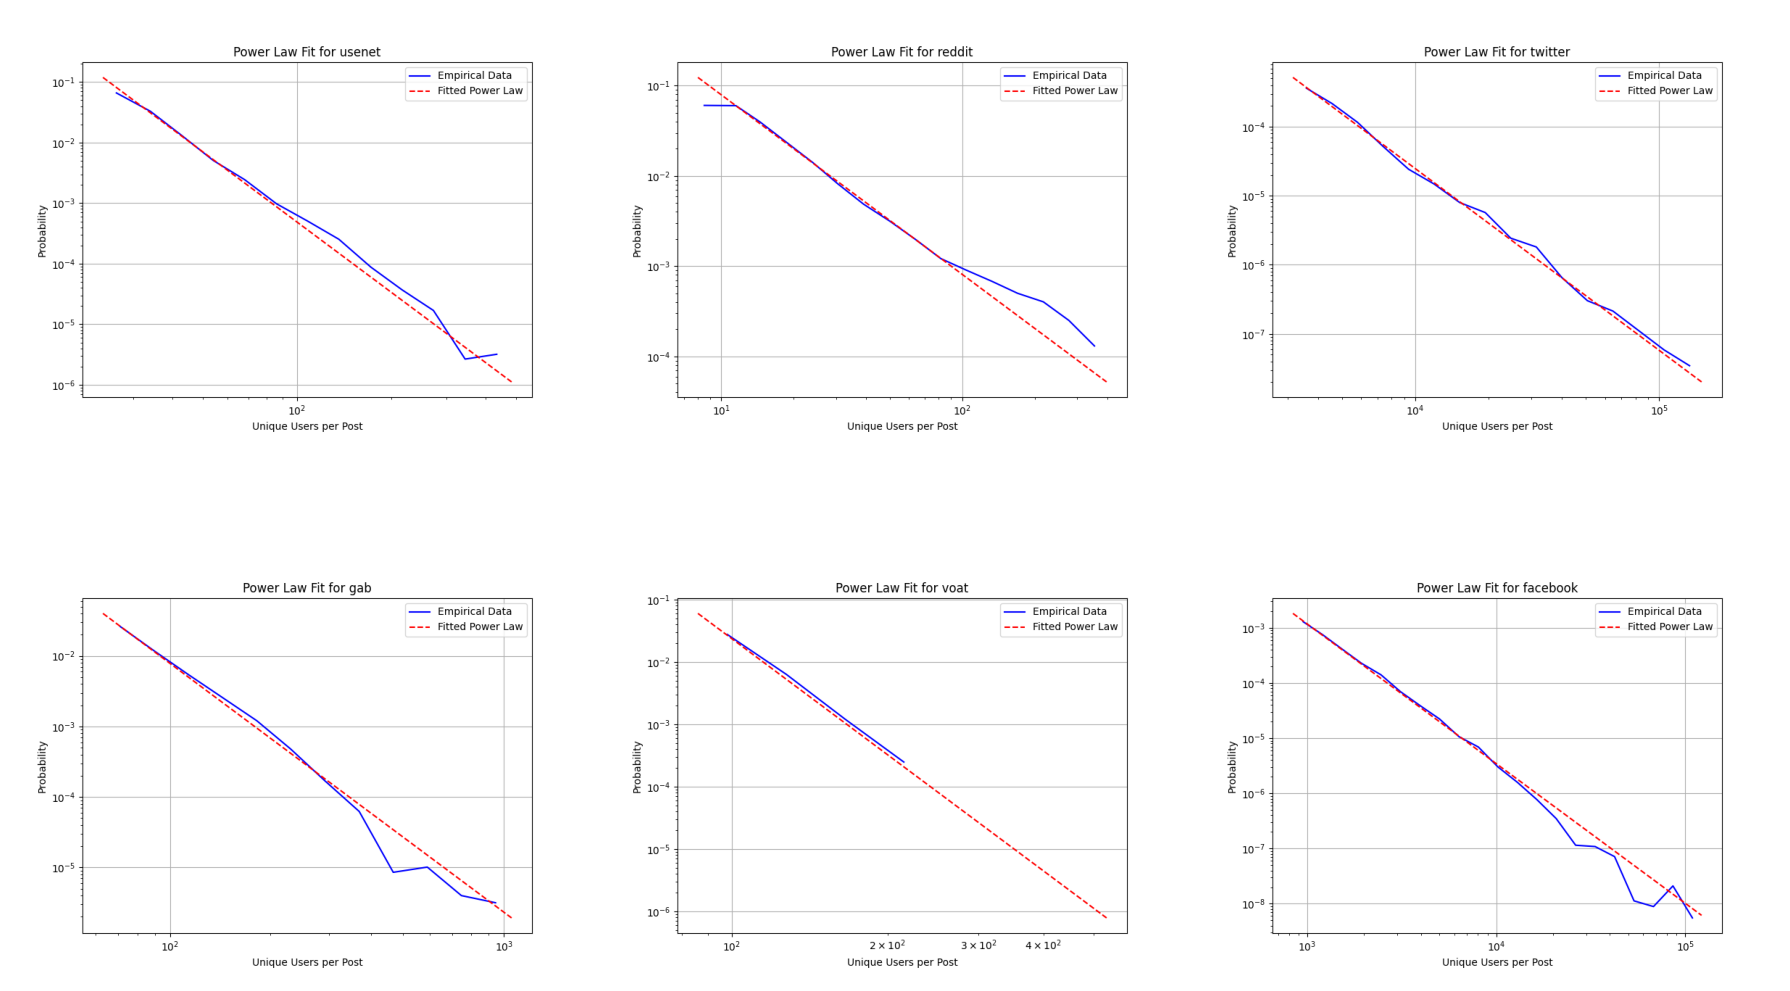

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['5_size_effect'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [root + 'PAPER/output/plots/usenet_power_law_fit.png',
              root + 'PAPER/output/plots/reddit_power_law_fit.png', 
              root + 'PAPER/output/plots/twitter_power_law_fit.png',
                      root + 'PAPER/output/plots/gab_power_law_fit.png', 
              root + 'PAPER/output/plots/voat_power_law_fit.png',
              root + 'PAPER/output/plots/facebook_power_law_fit.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/plots/SI_1.png'
    plt.savefig(combined_image_path)
    plt.show()

# Collective

## Lifetime collective

In [4]:
# Concatenare tutti i dati
all_data = []

for platform in tqdm(platforms):
    data = pd.read_parquet(
        root + f'DATA/{platform}/{platform}_raw_data.parquet',
        columns=columns_to_read[platform]
    )
    data.columns = standard_columns
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

    output_path = root + f'PAPER/output/1_section/2_lifetime_thread_{platform}.csv'
    if not os.path.exists(output_path):
        calculate_lifetime_percentile(data, 99, output_path, sample=10000)

    # Leggi i dati processati
    df = pd.read_csv(output_path, dtype={'post_id': str})
    df['duration_percentile'] = pd.to_numeric(df['duration_percentile'], errors='coerce')
    df['duration_percentile'].fillna(0, inplace=True)
    df = df[df['duration_percentile'] > 1]

    # Aggiungi il nome della piattaforma
    df['platform'] = platform
    all_data.append(df)


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_75801/3426250944.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['duration_percentile'].fillna(0, inplace=True)
 17%|█▋        | 1/6 [00:14<01:10, 14.13s/it]/tmp/ipykernel_75801/3426250944.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

/tmp/ipykernel_75801/1507759492.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=df, x="platform", y="duration_percentile", palette=palette, showfliers=False)
/tmp/ipykernel_75801/1507759492.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(platforms_capitalized)


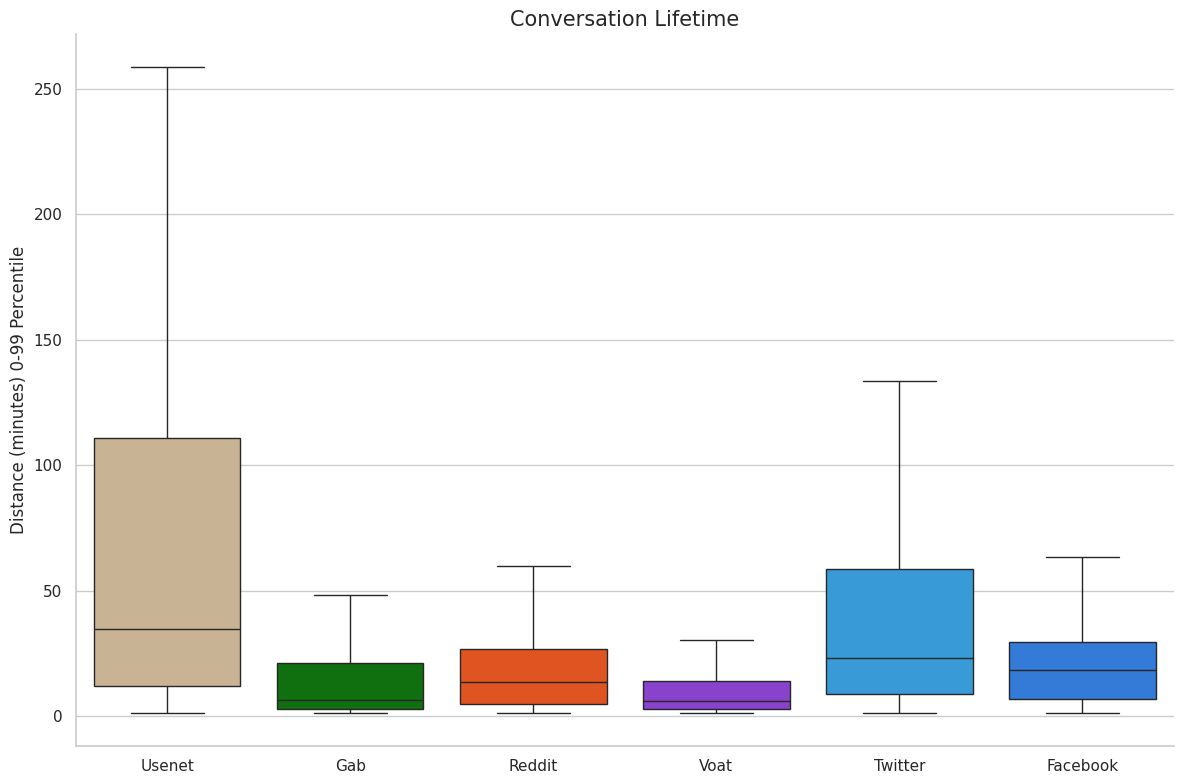

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Concatena tutti i dati in un unico DataFrame
df = pd.concat(all_data, ignore_index=True)

# Capitalizza i nomi delle piattaforme
platforms = ['usenet', 'gab', 'reddit', 'voat', 'twitter', 'facebook']
platforms_capitalized = [platform.capitalize() for platform in platforms]

# Boxplot combinato
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Crea il boxplot
g = sns.boxplot(data=df, x="platform", y="duration_percentile", palette=palette, showfliers=False)

# Aggiungi la personalizzazione per le etichette
g.set_xticklabels(platforms_capitalized)

sns.despine()

plt.title("Conversation Lifetime", fontsize=15)
plt.ylabel("Distance (minutes) 0-99 Percentile")
plt.xlabel('')
plt.tight_layout()

# Salva e mostra il grafico
combined_image_path = root + 'PAPER/output/plots/SI_2.png'
plt.savefig(combined_image_path)
plt.show()


# Individual

## Individual lifetime 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize a list to store the data for each platform
time_diff_data = []
platforms = ['voat', 'reddit', 'facebook', 'gab', 'twitter', 'usenet']

# Loop through platforms
for platform in tqdm(platforms):
    # Read data and filter for the required columns
    df = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', 
                         columns=columns_to_read[platform])
    df.columns = standard_columns

    # Assure 'created_time' is datetime type
    df['created_time'] = pd.to_datetime(df['timestamp'])

    # Create a 'user-post' pair by combining 'user_id' and 'post_id'
    df['user_post_pair'] = df['user_id'].astype(str) + '_' + df['post_id'].astype(str)

    # Take a random sample of 5000 unique user-post pairs
    sampled_user_post_pairs = df['user_post_pair'].drop_duplicates().sample(n=10000, random_state=42)

    # Filter the original DataFrame to include only the sampled user-post pairs
    df_sampled = df[df['user_post_pair'].isin(sampled_user_post_pairs)]

    # Sort the data by created time, user ID, and post ID
    df_sampled = df_sampled.sort_values(by=['created_time', 'user_id', 'post_id'])

    # Calculate the time difference in hours
    df_sampled['time_diff'] = df_sampled.groupby(['user_id', 'post_id'])['created_time'].diff()
    df_sampled['time_diff_hours'] = df_sampled['time_diff'].dt.total_seconds() / (60)

    # Fill NA values (e.g., for the first row of each group)
    df_sampled['time_diff_hours'] = df_sampled['time_diff_hours'].fillna(0)

    # Append the data to the list with a new column indicating the platform
    df_sampled['platform'] = platform
    time_diff_data.append(df_sampled)

# Combine all data into a single DataFrame for plotting
combined_df = pd.concat(time_diff_data, axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df.to_csv(root+'PAPER/output/SI/individual/interaction_lifetimes_all.csv')

100%|██████████| 6/6 [03:15<00:00, 32.54s/it]


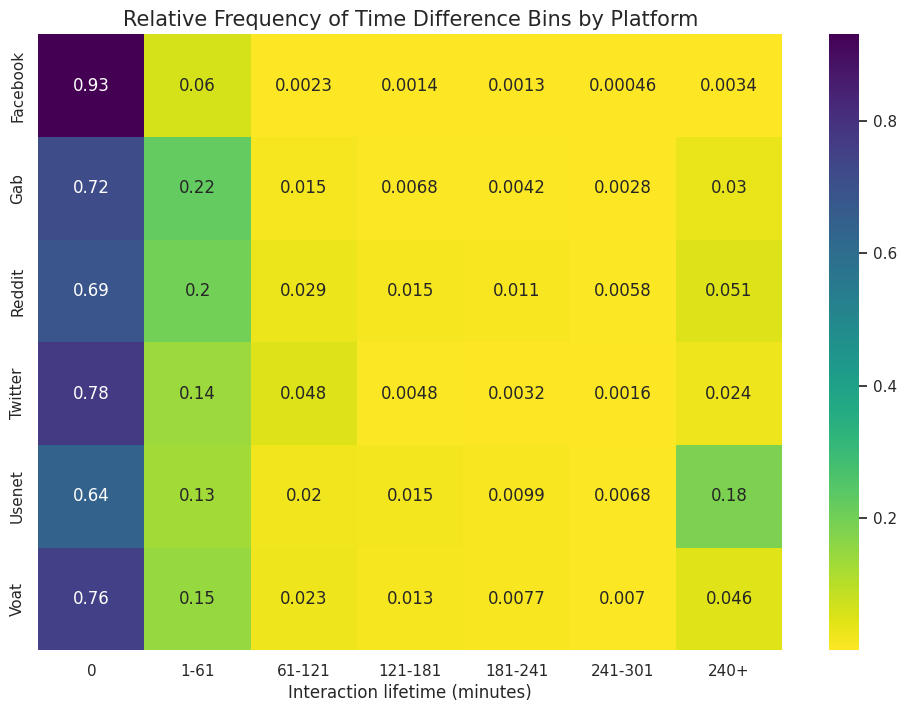

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_df = pd.read_csv(root+'PAPER/output/SI/individual/interaction_lifetimes_all.csv')

# Define the bins and labels
bins = [0] + list(range(1, 360, 60)) + [float('inf')]
labels = [0] + [f"{i}-{i+60}" for i in range(1, 300, 60)] + ['240+']

# Create the bins for 'time_diff_hours'
combined_df['binned_time_diff'] = pd.cut(combined_df['time_diff_hours'], bins=bins, labels=labels, right=False)

# Calculate the frequency of each bin for each platform
platform_bin_counts = combined_df.groupby('platform')['binned_time_diff'].value_counts(normalize=True).unstack(fill_value=0)

# Capitalize platform names
platform_bin_counts.index = platform_bin_counts.index.str.capitalize()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(platform_bin_counts, annot=True, cmap="viridis_r", cbar=True, xticklabels=platform_bin_counts.columns, yticklabels=platform_bin_counts.index)

# Set labels and title
plt.xlabel('Interaction lifetime (minutes)')
plt.ylabel('')
plt.title('Relative Frequency of Time Difference Bins by Platform' ,fontsize=15)

combined_image_path = root + 'PAPER/output/plots/SI_3.png'
plt.savefig(combined_image_path)
plt.show()


## Numero Tokens

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pyarrow.parquet as pq

# Initialize a list to store the data for each platform
time_diff_data = []
platforms = ['voat']  # You can expand this list with more platforms if needed
root = '/home/jacoponudo/Documents/Size_effects/'

# Define parameters for smoothing and filtering
time_window = 4  # Define the time window for the moving average
ignore_under = 5  # Define the threshold for ignoring low counts of unique users

# Loop through platforms
for platform in tqdm(platforms):

    # Read the parquet file
    table = pq.read_table(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet')
    
    # Convert to pandas DataFrame
    df = table.to_pandas()
    
    # Check the columns available in the DataFrame
    print(df.columns)
    
    # Count characters in the 'text' column, handle None/NaN values
    df['text_length'] = df['text'].apply(lambda x: len(x) if x is not None else 0)
    
    # Convert timestamp to datetime and extract week
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert timestamp to datetime
    df['week'] = df['timestamp'].dt.to_period('W')  # Extract the week from timestamp

    # Group by 'page_id' and 'week' to count unique users
    weekly_unique_users = df.groupby(['page_id', 'week'])['user_id'].nunique().reset_index()
    weekly_unique_users.rename(columns={'user_id': 'unique_users_count'}, inplace=True)
    
    # Sort the data for later use
    weekly_unique_users = weekly_unique_users.sort_values(by=['page_id', 'week'])
    
    # Apply a moving average for smoothing on the unique user count
    weekly_unique_users['smoothed_users_count'] = (
        weekly_unique_users.groupby('page_id')['unique_users_count']
        .rolling(window=time_window, min_periods=1)
        .mean().reset_index(level=0, drop=True)
    )
    
    # Filter out entries with outreach lower than the threshold
    weekly_unique_users = weekly_unique_users[weekly_unique_users['unique_users_count'] > ignore_under]

    # Merge the result back into the original df (based on 'page_id' and 'week')
    df = pd.merge(df, weekly_unique_users[['page_id', 'week', 'unique_users_count', 'smoothed_users_count']],
                  on=['page_id', 'week'], how='left')

    # Print or plot the result (example: print the first few rows)
    print(df[['text', 'text_length', 'unique_users_count', 'smoothed_users_count']].head())

    # Optionally, add the platform data to the time_diff_data list for further analysis
    time_diff_data.append(df)


  0%|          | 0/1 [00:00<?, ?it/s]

Index(['comment_id', 'text', 'video_id', 'user', 'upvotes', 'downvotes',
       'depth', 'root_submission', 'topic', 'toxicity_score', 'created_at',
       'social'],
      dtype='object')


  0%|          | 0/1 [00:05<?, ?it/s]


KeyError: 'timestamp'

In [6]:
table

pyarrow.Table
comment_id: string
text: string
video_id: bool
user: string
upvotes: double
downvotes: double
depth: double
root_submission: string
topic: string
toxicity_score: double
created_at: timestamp[us, tz=UTC]
social: string
----
comment_id: [["21427603","16956504","16830079","19933130","21810561",...,"13645820","16959568","24921056","12626006","23839103"],["19827241","15359559","17181999","16883422","18699118",...,"17206021","20849678","21263634","26422595","21171764"],...,["17439120","15143038","67426","25432252","13138656",...,"15791357","25770980","13453229","10384243","4599604"],["15186458","4008915","15047710","24427939","22746123",...,"25842895","8889041","8770998","17717905","11944246"]]
text: [["So, itâs essentially the Human Fund from Seinfeld?","This looks like an older wall.  I bet the new one is a bit beefier.","In other words, they cut a deal and rolled on him.","I've been doing this for years","Bullshit.  You are loved by me.  Non homo love. Just to be clear!",.

In [52]:
df

,post_id,user_id,timestamp,text
0,3527171,Charilko,2019-11-21 01:28:48+00:00,"So, itâs essentially the Human Fund from Sei..."
1,3054453,QPilledLib,2019-02-22 21:00:17+00:00,This looks like an older wall. I bet the new ...
2,3041556,GayBlackJew,2019-02-16 21:32:54+00:00,"In other words, they cut a deal and rolled on ..."
3,3357323,con77,2019-07-28 16:44:48+00:00,I've been doing this for years
4,3571793,21810561?,2019-12-20 21:05:44+00:00,Bullshit. You are loved by me. Non homo love...
...,...,...,...,...
3506694,4049464,Ducktalesooo000ooo,2020-10-02 22:11:49+00:00,The first person I catch wearing a punisher sk...
3506695,1816014,guinness2,2017-04-24 21:31:19+00:00,Consider President Trump's threats about label...
3506696,1791471,watch_listed,2017-04-13 19:56:40+00:00,That must be some damn good cake. Think I coul...
3506697,3127533,recon_johnny,2019-03-29 22:50:18+00:00,"Of course she does. No internal realization, n..."


# Alpha

## Plot 4 with Alpha

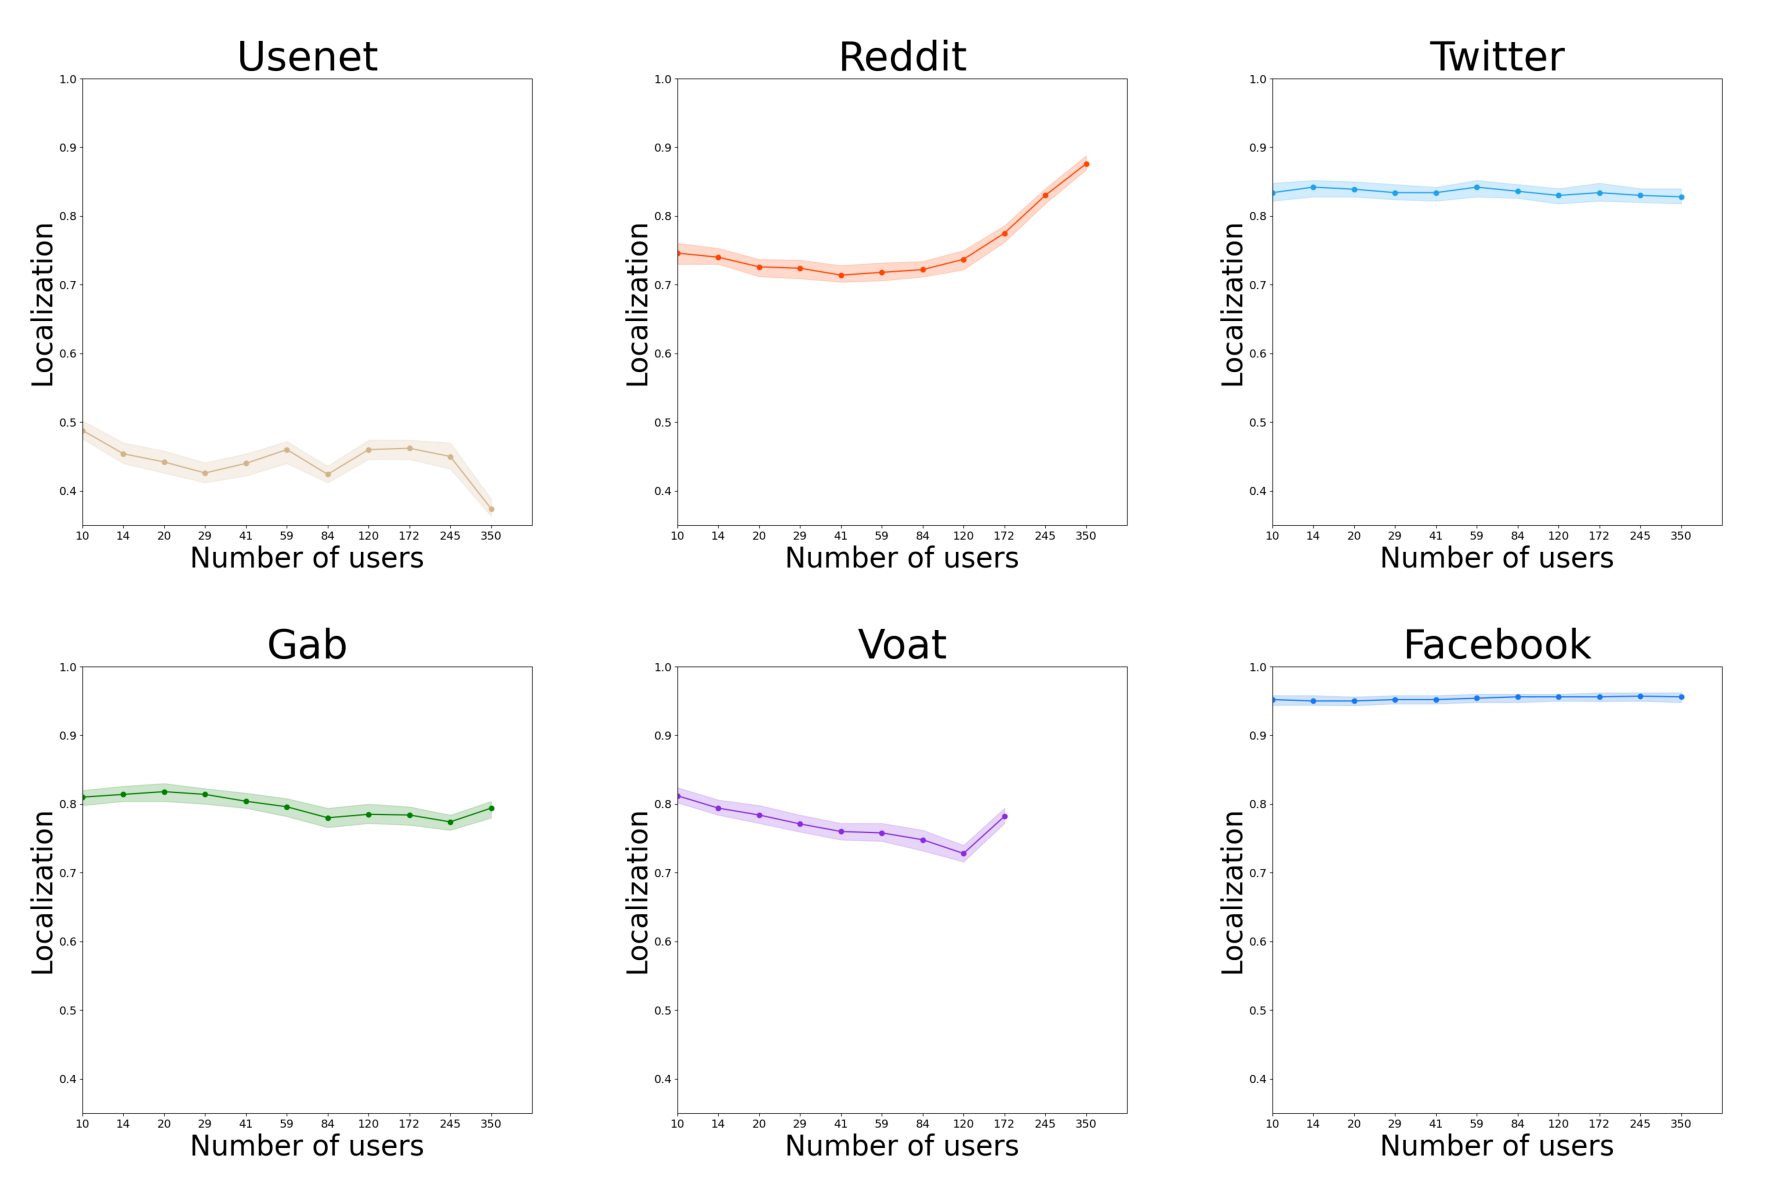

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['4_dialogue_level'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):

    images = [
                root + 'PAPER/output/1_section/' + plot + '_usenet_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_reddit_alpha.png', 
    root + 'PAPER/output/1_section/' + plot + '_twitter_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_gab_alpha.png', 
    root + 'PAPER/output/1_section/' + plot + '_voat_alpha.png',
    root + 'PAPER/output/1_section/' + plot + '_facebook_alpha.png']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  
        
    plt.tight_layout()
    combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '_alpha.png'
    plt.savefig(combined_image_path)
    plt.show()

## Plot 3 with Alpha

/tmp/ipykernel_382110/3345931861.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df, x="Platform", y="Alpha", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)
/tmp/ipykernel_382110/3345931861.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(data=df, x="Platform", y="Alpha", palette=palette, size=2, ax=g.ax,alpha=0.1)


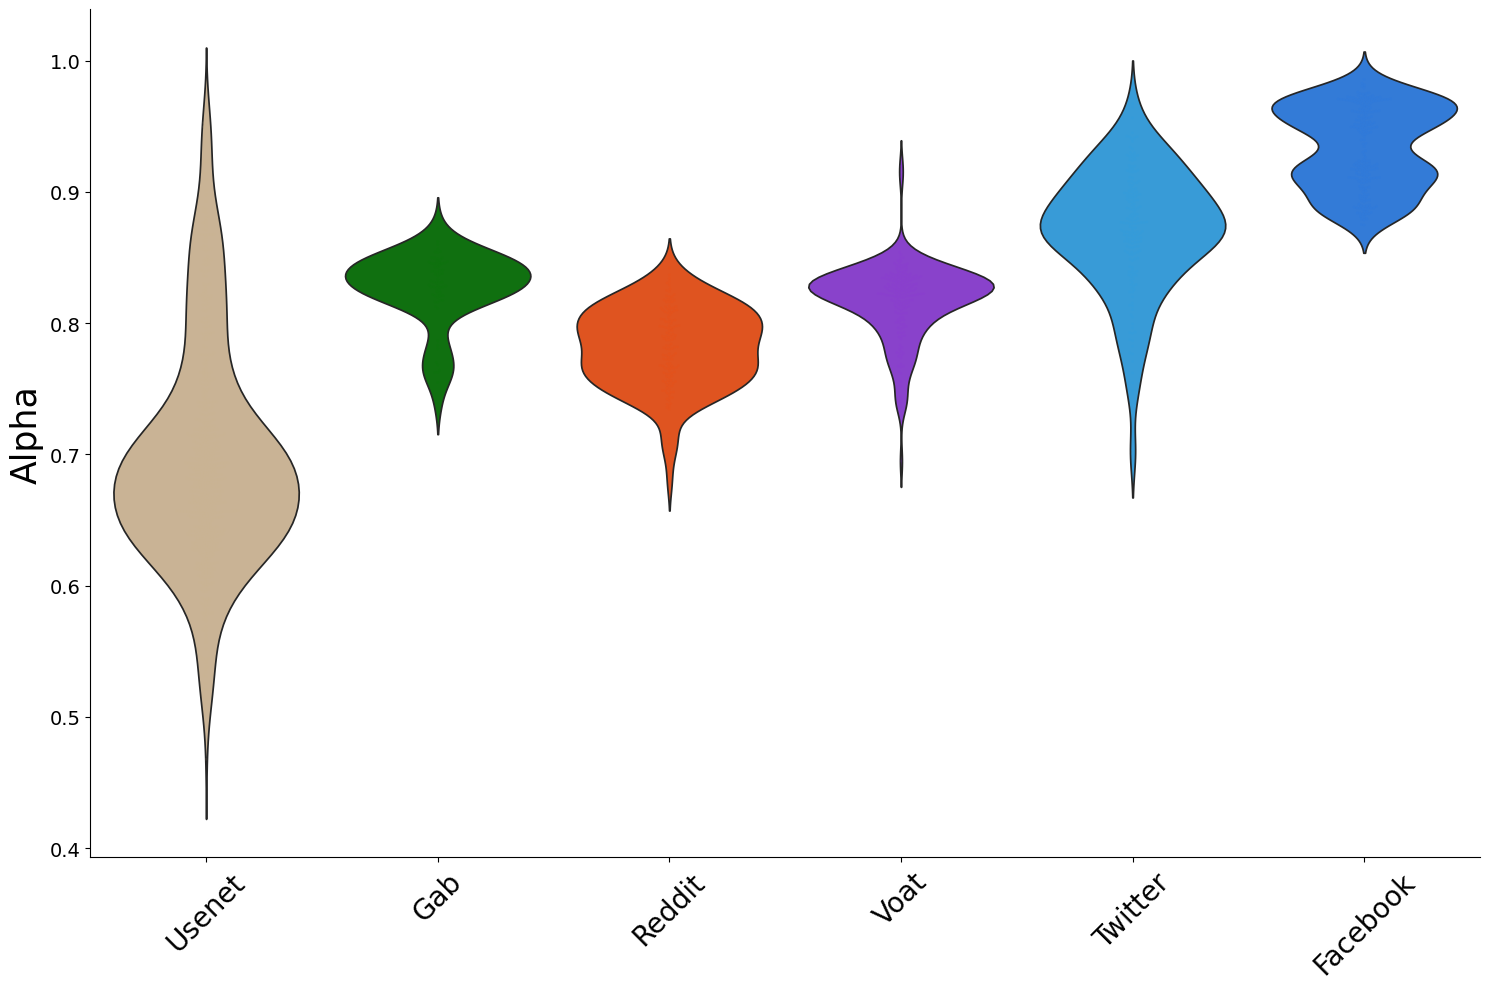

In [2]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['usenet','gab','reddit',  'voat', 'twitter','facebook']
type='Localization'

# Load the dataset
df = pd.read_csv(root + 'PAPER/output/3_section/boxplot_localization.csv')

# Order the platforms if needed (make sure 'platforms' is defined)
df['Platform'] = pd.Categorical(df['Platform'], categories=platforms, ordered=True)

# Create the violin plot using catplot
g = sns.catplot(data=df, x="Platform", y="Alpha", kind="violin", inner=None, palette=palette,    height=d1, aspect=1.5)

# Add the swarmplot on top of the violin plot
sns.swarmplot(data=df, x="Platform", y="Alpha", palette=palette, size=2, ax=g.ax,alpha=0.1)

# Customizing plot labels and title
plt.xlabel('', fontsize=0)
plt.ylabel('Alpha', fontsize=25)
plt.yticks(fontsize=t)

# Convert platform names to uppercase
plt.xticks(ticks=range(len(platforms)), labels=[platform.capitalize() for platform in platforms], rotation=45,fontsize=20)

# Remove the box around the plot
sns.despine()

plt.tight_layout()
combined_image_path = root + 'PAPER/output/plots/3_alpha.png'
plt.savefig(combined_image_path)
plt.show()

## Plot 5 with alpha

FileNotFoundError: [Errno 2] No such file or directory: '/home/jacoponudo/Documents/Size_effects/PAPER/output/4_section/5_size_effect_twitter_alpha.png'

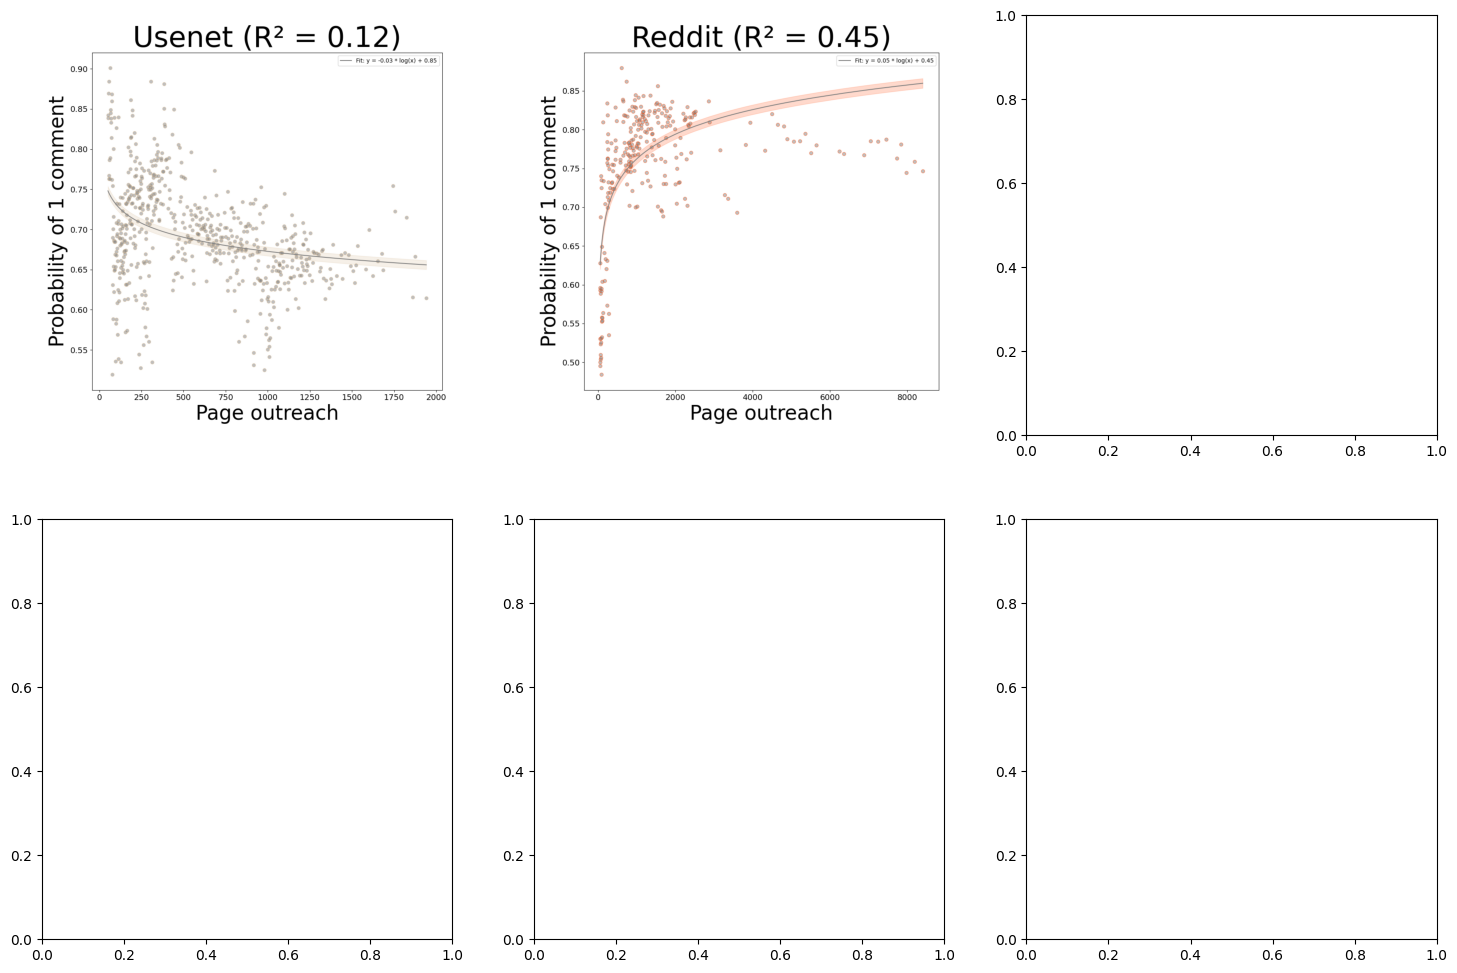

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['5_size_effect'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [            root + 'PAPER/output/4_section/' + plot + '_usenet_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_reddit_alpha.png', 
              root + 'PAPER/output/4_section/' + plot + '_twitter_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_gab_alpha.png', 
              root + 'PAPER/output/4_section/' + plot + '_voat_alpha.png',
              root + 'PAPER/output/4_section/' + plot + '_facebook_alpha.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/plots/' + plot[0] + '_alpha.png'
    plt.savefig(combined_image_path)
    plt.show()

### Super scatterplot

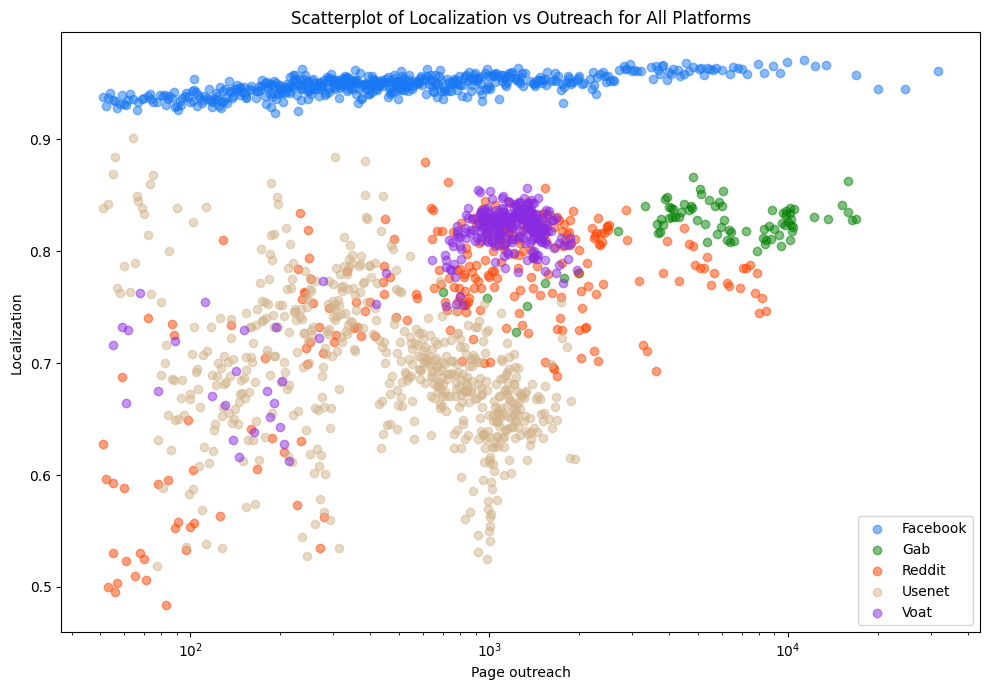

In [10]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import os
# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['reddit','voat','usenet','gab','facebook']#,'twitter','facebook']
type='_alpha'
all_data = []

for platform in platforms:
    merged_df = pd.read_csv(root + f'PAPER/output/4_section/5_size_effect_{platform+type}.csv')
    merged_df['binned_lower'] = merged_df['binned'].apply(lambda x: float(x.split(',')[0][1:])).round()
    merged_df = merged_df.dropna(subset=['binned_lower', 'localization_parameter'])
    merged_df = merged_df[np.isfinite(merged_df['localization_parameter'])]
    merged_df['platform'] = platform
    all_data.append(merged_df)

combined_df = pd.concat(all_data, ignore_index=True)

plt.figure(figsize=(10, 7))
colors=palette

for platform, group in combined_df.groupby('platform'):
    plt.scatter(group['binned_lower'], group['localization_parameter'],label=platform.capitalize(), color=colors[platform], alpha=0.5)

plt.xlabel('Page outreach')
plt.ylabel('Localization')
plt.title('Scatterplot of Localization vs Outreach for All Platforms')
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()


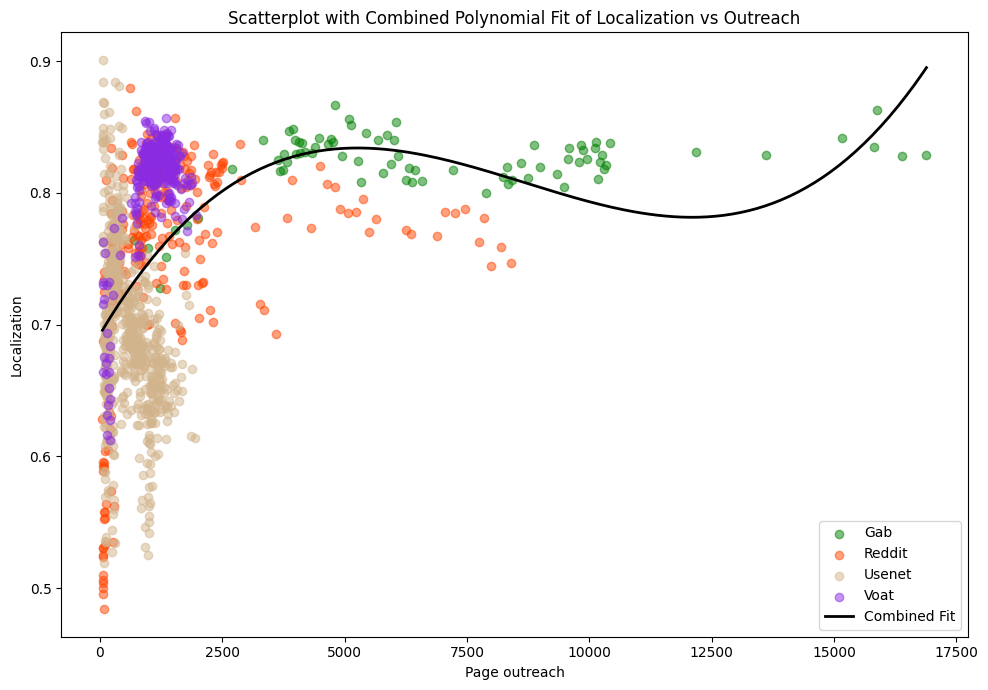

In [8]:
# Polynomial fit for all platforms combined
from numpy.polynomial.polynomial import Polynomial

plt.figure(figsize=(10, 7))
colors = palette

# Scatter plot for all platforms
for platform, group in combined_df.groupby('platform'):
    plt.scatter(group['binned_lower'], group['localization_parameter'], label=platform.capitalize(),
                color=colors[platform], alpha=0.5)

# Polynomial fit
x = combined_df['binned_lower']
y = combined_df['localization_parameter']
coeffs = np.polyfit(x, y, deg=3)  # Adjust degree as needed
poly = np.poly1d(coeffs)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = poly(x_fit)

# Plot combined polynomial fit
plt.plot(x_fit, y_fit, color='black', linewidth=2, label='Combined Fit')

plt.xlabel('Page outreach')
plt.ylabel('Localization')
plt.title('Scatterplot with Combined Polynomial Fit of Localization vs Outreach')
plt.legend()
plt.tight_layout()
plt.show()
